# Radio Prac

#### Imports

In [77]:
#Required imports
from astropy.io import fits
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.coordinates import ICRS, LSR
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
data_dir = os.getcwd() + '\\Observation\\FITS'
ref_dir = os.getcwd() + '\\l_297_b_-15'
gal_longitudes = [28, 320, 326]

### Reducing Observation Data 

In [78]:
fits_files = [f for f in os.listdir(data_dir) if f.endswith('.fits')]
fits_files.sort()
# Split fits filenames into 3 groups of 3: (3 Targets each with 3 200 second exposures)
targets = [fits_files[i:i+3] for i in range(0, len(fits_files), 3)]

In [179]:
def process_pol(data, key:str, statuses):
    """Helper function to process polarimetry data."""
    pol_data = data[key]
    pol_data = np.column_stack((statuses, pol_data))  # Add 'status' column
    pol_data = pol_data[np.char.strip(pol_data[:, 0]) != 'cal']  # Filter out calibrations
    return np.sum(pol_data[:, 1:].astype(float), axis=0)  # Sum measurements across the frequencies

def read_fits_table(filepath: str) -> tuple:
    with fits.open(filepath) as hdul:
        # Extract data into a dictionary
        data = {column.name: hdul[1].data[column.name] for column in hdul[1].columns}
        
        statuses = data['STATUS']  # Extract statuses

        # Process both RIGHT_POL and LEFT_POL
        data['RIGHT_POL'] = process_pol(data, 'RIGHT_POL', statuses)
        data['LEFT_POL'] = process_pol(data, 'LEFT_POL', statuses)

        return data, hdul[1].header

data, head = read_fits_table('20240919-101005_SPECTRUM-PROJ01-GAL_01#_01#.fits')
# for key in data.keys():
#     print(data[key].shape)
head

XTENSION= 'BINTABLE'           / Table Extension                                
BITPIX  =                    8 / Binary data                                    
NAXIS   =                    2 / Two_dimensional table array                    
NAXIS1  =                16460 / Bytes per row (16460)                          
NAXIS2  = 30                     / NAXIS2 is ydimension of table array          
PCOUNT  =                    0 / Number of bytes following data matrix          
GCOUNT  =                    1 / Only one group                                 
TFIELDS =                   11 / Number of columns in the table                 
TFORM1  = '1D        '           / 1 double precision fp #8 bytes               
TTYPE1  = 'JD        '           / Julian Day                                   
TUNIT1  = 'd         '           / Days                                         
TFORM2  = '1D        '           / 1 double precision fp #8 bytes               
TTYPE2  = 'Azimuth   '      

In [3]:
from astropy.io import fits
target_spectra = []

# Loop over each target
for target in targets:
    summed_600sec = None

    # Loop over each FITS file for the current target
    for third in target:
        # Define the path to the FITS file
        fits_path = os.path.join(data_dir, third)

        # Open the FITS file using a context manager to ensure proper closing
        with fits.open(fits_path) as hdul:
            # Extract the 'LEFT_POL' data from the second HDU (index 1)
            data = hdul[1].data['LEFT_POL']

            # Remove every third element from the data (based on the index)
            removed_cal = np.array([data[i, :] for i in range(data.shape[0]) if (i + 1) % 3 != 0])

            # Sum the remaining data (200 seconds summed for this file)
            summed_200sec = np.sum(removed_cal, axis=0)

            # Accumulate the summed spectra for each FITS file
            if summed_600sec is None:
                summed_600sec = summed_200sec  # First FITS file, initialize summed_600sec
            else:
                summed_600sec += summed_200sec  # Subsequent FITS files, add to existing sum

    # Append the summed spectrum as a DataFrame to the list for the current target
    target_spectra.append(pd.DataFrame({'counts': summed_600sec}))

DIAMETER =                    3  / TELESCOPE diameter                            [astropy.io.fits.card]


### Generate frequency axis as middle of s.t. ADU counts are at the centers of 1024 bins of width $\frac{\text{Bandwidth}}{1024} \equiv \text{Band Resolution}$

In [182]:
from astropy.io import fits
with fits.open(os.path.join(data_dir, targets[0][1])) as hdul:
    fits = hdul[1]
    header = hdul[1].header
    f0 = header['BASEFREQ']
    BW = header['BANDWID']
    df = header['BNDRES'] ## Use resolution as frequency binwidth
    # df = BW/ 1024 ## Use BandWidth and Magic number 1024 as frequency binwidth
    # df = pd.DataFrame(fits.data)
freq = np.arange(f0 + df/2, f0 + BW + df, df)/10**9

# Give each longitude data a frequency axis
for target in target_spectra:
    target['frequency'] = freq

fits.columns

ColDefs(
    name = 'JD'; format = '1D'; unit = 'd'
    name = 'Azimuth'; format = '1D'; unit = 'deg'
    name = 'Elevation'; format = '1D'; unit = 'deg'
    name = 'Az_Offset'; format = '1D'; unit = 'deg'
    name = 'El_Offset'; format = '1D'; unit = 'deg'
    name = 'Gal_Long'; format = '1D'; unit = 'deg'
    name = 'Gal_Lat'; format = '1D'; unit = 'deg'
    name = 'LEFT_POL'; format = '1024K'; unit = 'count'
    name = 'RIGHT_POL'; format = '1024K'; unit = 'count'
    name = 'STATUS'; format = '4A'
    name = 'MARKER'; format = '16A'
)

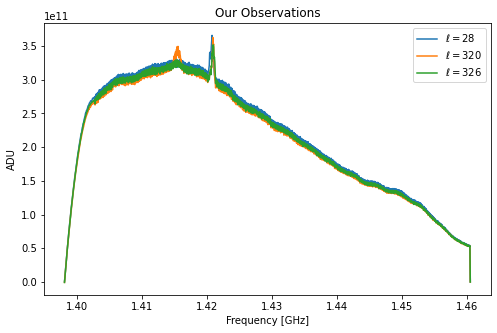

In [5]:
# %matplotlib widget
# plt.clf()
# with fits.open(os.path.join(data_dir, targets[0][0])) as hdul:
#             data1 = hdul[1].data['LEFT_POL'][1,:]

fig, ax = plt.subplots(1, figsize=(8, 5))
for i,spectrum in enumerate(target_spectra):
    # if i!=1:
    #     continue
    ax.plot(target_spectra[i]['frequency'], target_spectra[i]['counts'], label=f'$\\ell=${gal_longitudes[i]}')
# ax.plot(freq, data1, label='$\\ell = 28$ (10s)')
ax.set(xlabel='Frequency [GHz]', ylabel='ADU', title='Our Observations')

ax.legend()
plt.show()

### Surface Brightness Calibration

In [6]:
ref_fits_files = [f for f in os.listdir(ref_dir) if f.endswith('.fits')]
ref_fits_files.sort()
# Split fits filenames into 3 groups of 3: (3 Targets each with 3 200 second exposures)
# targets = [fits_files[i:i+3] for i in range(0, len(fits_files), 3)]
ref_fits_files

['20210912-060233_SPECTRUM-PROJ01-GAL_01#_01#.fits',
 '20210912-061012_SPECTRUM-PROJ01-GAL_02#_01#.fits',
 '20210912-061658_SPECTRUM-PROJ01-GAL_03#_01#.fits',
 '20210912-062349_SPECTRUM-PROJ01-GAL_04#_01#.fits',
 '20210912-063041_SPECTRUM-PROJ01-GAL_05#_01#.fits']

## Extracting and Stacking (Sum) Reference Spectrum 

In [7]:
from astropy.io import fits
with fits.open(os.path.join(ref_dir, ref_fits_files[3])) as hdul1:
    # Extract the data from the second HDU (index 1)
    cal_data = hdul1[1].data

    # Calculate the galactic longitude (mean of the 'Gal_Long' column)
    cal_long = np.mean(cal_data['Gal_Long'])

    # Extract the galactic latitude and other data
    cal_lat = cal_data['Gal_Lat']
    cal_header = hdul1[1].header

    # Corrected central frequency and bandwidth
    cal_f0 = 1428.75  # Corrected central frequency (in Hz)
    cal_obs = cal_header['OBSFREQ ']
    cal_BW = cal_header['BANDWID']  # Bandwidth from the header
    beam_width = cal_header['BMAJ']  # Beam major axis (in degrees)

    # Optionally, you can calculate the frequency bin width if needed
    # df = cal_BW / 1024  # Bandwidth divided by a magic number (1024)

# Output the header for inspection (if needed)
# cal_obs


DIAMETER =                    3  / TELESCOPE diameter                            [astropy.io.fits.card]


In [8]:
from astropy.io import fits
summed_ref_spectrum = None
avg_gal_longs = []
avg_gal_lats = []
for spec in ref_fits_files:
    file_path = os.path.join(ref_dir, spec)
    with fits.open(file_path) as hdul:
        # Check if hdul[1] is a BinTableHDU
        if isinstance(hdul[1], fits.BinTableHDU):
            data = hdul[1].data['RIGHT_POL']
            avg_gal_longs.append(np.mean(hdul[1].data['Gal_Long']))
            avg_gal_lats.append(np.mean(hdul[1].data['Gal_Lat']))
            removed_cal = np.array([data[i, :] for i in range(data.shape[0]) if (i + 1) % 3 != 0])
            summed_200sec = np.sum(removed_cal, axis=0)  # Use removed_cal if that's the intention

            if summed_ref_spectrum is None:
                summed_ref_spectrum = summed_200sec
            else:
                summed_ref_spectrum += summed_200sec
avg_gal_long = np.mean(np.array(avg_gal_longs))
avg_gal_lat = np.mean(np.array(avg_gal_lats))
print(f'{avg_gal_long=}, {avg_gal_lat=}, {beam_width=}')
summed_ref_spectrum.shape

avg_gal_long=207.30119974014073, avg_gal_lat=-14.417381999977476, beam_width=4.03376144265431


(1024,)

### frequency scale for reference spectrum 

In [9]:
freq1 = np.arange(cal_f0 - cal_BW / 2, cal_f0 + cal_BW / 2, cal_BW/1024)/10**3
ref_spectrum = pd.DataFrame({'frequency': freq1, 'counts': summed_ref_spectrum})
ref_spectrum

,frequency,counts
0,1.397500,-148332025
1,1.397561,3434340974
2,1.397622,6582458602
3,1.397683,9613987419
4,1.397744,12603814649
...,...,...
1019,1.459695,17551577505
1020,1.459756,17239751916
1021,1.459817,17519054968
1022,1.459878,17311203946


### Plotting Reference Spectrum

In [10]:
filtered_spectrum = ref_spectrum[(ref_spectrum['frequency'] > max_ref_freq) & (ref_spectrum['frequency'] < min_ref_freq)]
filtered_spectrum

NameError: name 'max_ref_freq' is not defined

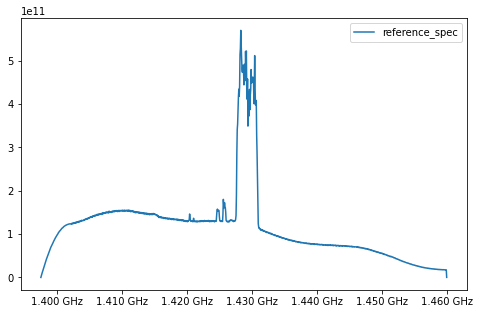

In [14]:
import matplotlib.ticker as ticker

# Assuming 'ref_spectrum' has 'frequency' in Hz
# Convert to GHz if necessary
ref_spectrum['frequency'] = ref_spectrum['frequency']

# Set up the figure
fig1, ax1 = plt.subplots(1, figsize=(8, 5))

# Plot the data
ax1.plot(ref_spectrum['frequency'], ref_spectrum['counts'], label='reference_spec')
# filtered_spectrum_df
# Set axis labels and titleax1.set(xlabel='Frequency [GHz]', ylabel='ADU', title='Reference Spectrum')

# Use a formatter to control how the x-axis is displayed (in GHz, 3 decimal places)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f} GHz'))

# Add the legend
ax1.legend()

# Show the plot
plt.show()


### Compare Reference Spectrum to HI Profile

#### https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php

In [15]:
HI_profile = np.loadtxt('HI_profile.csv', delimiter=',', encoding='utf-8', usecols=[2,1])
HI_profile.shape
HI_profile = pd.DataFrame({'frequency': HI_profile[:,0]/10**3, 'b_temp': HI_profile[:,1]})
HI_profile

,frequency,b_temp
0,1.422300,0.00
1,1.422300,-0.01
2,1.422290,0.00
3,1.422290,0.00
4,1.422280,0.00
...,...,...
772,1.418531,0.00
773,1.418526,-0.01
774,1.418521,-0.01
775,1.418516,-0.01


In [16]:
HI_profile['frequency'].min()

1.418511

#### Scaling the reference spectrum 21cm peak to a the HI profile 

In [36]:
min_ref_freq = HI_profile['frequency'].min()  # Define your minimum frequency
max_ref_freq = HI_profile['frequency'].max()  # Define your maximum frequency

# 2. Filter summed_ref_spectrum based on the specified frequency range
ref_spectrum_window = ref_spectrum[(ref_spectrum['frequency'] >= min_ref_freq) &
                                               (ref_spectrum['frequency'] <= max_ref_freq)]

# 3. Shift windowed spectrum down by mean
ref_mean = np.mean(ref_spectrum_window['counts'])
ref_spectrum_shifted_window = ref_spectrum_window - ref_mean

# 3. Get the counts within the specified frequency range
reference_max = ref_spectrum_shifted_window['counts'].max()

# 5. Find the scaling factor based on the maximum counts
scale_factor = HI_profile['b_temp'].max() / reference_max

#### Windowing, Scaling, and Flooring galactic longitudes 

In [40]:
wsf_spectra = []
for target in target_spectra:
    w_target_spectra = target[(target['frequency'] >= min_ref_freq) &
                                               (target['frequency'] <= max_ref_freq)]
    wf_target_spectra = w_target_spectra - w_target_spectra['counts'].mean()
    wsf_target_spectra = wf_target_spectra*scale_factor
wsf_spectra

[]

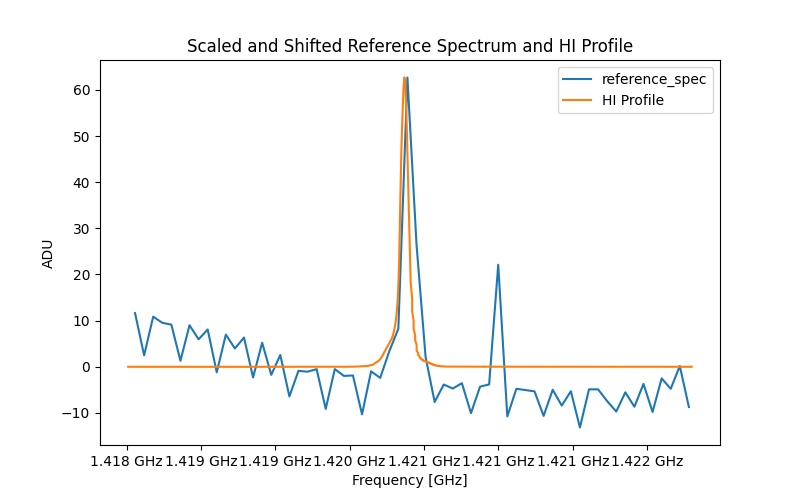

In [41]:
# %matplotlib widget
plt.clf()

fig2, ax2 = plt.subplots(1, figsize=(8, 5))
ax2.plot(ref_spectrum_window['frequency'], ref_spectrum_shifted_window['counts'] * scale_factor, label=f'reference_spec')
ax2.plot(HI_profile['frequency'], HI_profile['b_temp'], label=f'HI Profile')
ax2.set(xlabel='Frequency [GHz]', ylabel='ADU', title='Scaled and Shifted Reference Spectrum and HI Profile',
       yscale='linear')



# Use a formatter to control how the x-axis is displayed (in GHz, 3 decimal places)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f} GHz'))
ax2.legend()
plt.show()

## Correcting for LSR 

## `lsr_calc_1.1 Script` by Wolfgang Herrmann, Astropeiler Stockert

In [20]:
"""
vlsr_calc is a routine to do LSR corrections for radio astronomy using Astropy
In addition to the routine itself some examples of its usage are given
Author: Wolfgang Herrmann, Astropeiler Stockert
Version 1.1, August 7th, 2021
"""



"""
Here comes the routine to do the calculation
Required inputs:
obs_lon: Geographic longitude of the observatory in decimal degrees
obs_lat: Geographic latitude of the observatory in decimal degrees
obs_ht: Heigt of the observatory in meters
ra: Right ascension of the observed sky location in decimal hours
dec: Declination of the observed sky location in decimal degrees
time: Time of observation in UTC (Astropy format)
Note that there is a specific definiton of the peculiar motion of the sun
overriding the default.
This routine returns two values: The velocity of the observer with respect to
the solar system barycenter and the velocity of the observer with respect to
the local standard of rest.
"""
def vlsr_calc(obs_lon, obs_lat, obs_ht, ra, dec, time):
    obsloc = EarthLocation(lon=obs_lon*u.deg, lat=obs_lat*u.deg, height=obs_ht*u.m)
    skycoord = SkyCoord((ra*15.)*u.deg, dec*u.deg)
    vbary = skycoord.radial_velocity_correction(kind='barycentric', obstime=time, location=obsloc)  
    my_observation = ICRS((ra*15.)*u.deg, dec*u.deg, pm_ra_cosdec=0*u.mas/u.yr, pm_dec=0*u.mas/u.yr, \
    radial_velocity=vbary, distance = 1*u.pc)
    vlsr = my_observation.transform_to(LSR(v_bary=(10.27,15.32,7.74)*u.km/u.s)).radial_velocity
    return vbary,vlsr

#Now let's make an example how to use it
    
#Define the observatory location
#This example uses the coordinates of the Stockert observatory
obs_lon = 6.72194444
obs_lat = 50.569444
obs_ht  = 434.0

#Define the sky location observed
ra = 0.43
dec = 62.73

#Define the time of observation
#If you want to take the current time:
now = datetime.utcnow()
time=Time(now, scale='utc')

#Here is an example on how to give an explicit time
#Uncomment of you want to use this example
#mytime = '2021-08-07T00:00:00'
#time=Time(mytime, scale='utc')


#Throw this into the calculation and print
velocities = vlsr_calc(obs_lon, obs_lat, obs_ht, ra, dec, time)
print ("Example 1")
print ("VLSR: ",velocities[1])
print ("Barycentric velocity:", velocities[0])

#You will notice that it is printed with units
#This is because the velocities are returned as Astropy entities.
#You may want to have this as simple floating point numbers:
vlsr = velocities[1].value
vbary = velocities[0].value/1000.
print ("Same as pure numbers in km/s: ",vlsr,vbary)
print("***")

#Your may want to use this to convert frequencies. For this we need the
#speed of light and the rest frequency.
c=299792.458    #speed of light in km/s
rest_frequency = 1420.405 #Hydrogen line in MHz

#This example calculates the sky frequency of the hydrogen rest frequency.
#You could use this to adjust your receiver frequency to record spectra in the LSR frame
sky_frequency = rest_frequency *(1-vlsr/c)
print ("Example 3")
print ("Sky frequency of a hydrogen line at rest:", sky_frequency)
print("***")

#Another example is to determine the LSR velocity of a line observed without correction:
#So let's assume you have some hydrogen line at 1420.412 MHz
#observed_frequency=sky_frequency
observed_frequency = 1420.412
LSR_velocity=c*(1-(observed_frequency/rest_frequency))-vlsr
print ("Example 4")
print("LSR velocity:", LSR_velocity)

C:\Users\user\AppData\Local\Temp\ipykernel_11316\1725757759.py:48: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


Example 1
VLSR:  16.942604166989778 km / s
Barycentric velocity: 8809.528649126882 m / s
Same as pure numbers in km/s:  16.942604166989778 8.809528649126882
***
Example 3
Sky frequency of a hydrogen line at rest: 1420.3247266007545
***
Example 4
LSR velocity: -18.420032932709223


In [16]:
freq1

array([1.42874997, 1.42874997, 1.42874997, ..., 1.42875003, 1.42875003,
       1.42875003])

In [17]:
np.array([range(30)[i] for i in range(data.shape[0]) if (i) % 3 !=0])

array([ 1,  2,  4,  5,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25,
       26, 28, 29])

In [18]:
targets[0][0]

'20240919-101005_SPECTRUM-PROJ01-GAL_01#_01#.fits'

In [19]:
print(f'{1429250000:.2e}')

1.43e+09
